<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/RL-PortfolioOpt_StocVol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import numpy as np

import seaborn as sns
import numpy.matlib


import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import stats
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

import copy



In [118]:
#Setting seed
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(0)

In [119]:
# # 1 asset 
# params = {
#     "S0" : np.array([100]),
#     "mu" : np.array([0.03]),
#     "sigma" : np.array([0.8]),
#     "rho" : np.array([[1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.7])
#     }
# params_Q = copy.copy(params)
# params_Q["mu"] = np.array([params_Q["rf"]])


# ## 2 assets 
# params = {
#     "S0" : np.array([1, 1]),
#     "mu" : np.array([0.05, 0.05]),
#     "sigma" : np.array([0.05, 0.9]),
#     "rho" : np.array([[1, .25],[.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.5, 0.5])
#     }
# params_Q = copy.copy(params)
# params_Q["mu"] = np.array([params_Q["rf"],params_Q["rf"]])

## 4 assets 
# params = {
#     "S0" : np.array([1, 2,3,1]),
#     "mu" : np.array([0.5, 0.06, .06, .06]),
#     "sigma" : np.array([.7, 0.10 , .10, .10]),
#     "rho" : np.array([[1, 0.25,.25, .25],[0.25,1,.25, .25], [0.25,.25,1, .25], [0.25,.25,.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.2, 0.3, .3, .4 ])
#     }
#params_Q = copy.copy(params)
#params_Q["mu"] = np.array([params_Q["rf"], params_Q["rf"], params_Q["rf"], params_Q["rf"]])

print(params)

print(params_Q)

{'S0': array([100]), 'mu': array([0.05]), 'sigma': array([0.8]), 'rho': -0.2, 'kappa': array([[0.3]]), 'theta': array([[0.2]]), 'xi': array([[0.2]]), 'v0': array([0.2]), 'delta': array([0.7]), 'rf': 0.01}
{'S0': array([100]), 'mu': array([0.01, 0.01]), 'sigma': array([0.8]), 'rho': array([[1]]), 'rf': 0.01, 'delta': array([0.7])}


In [120]:
def SimPath(Ndt, params, T, Nsims):
    
    dt = T/Ndt
    
    N_assets= params["mu"].shape[0]
    
    assert N_assets == params["sigma"].shape[0], "#assets in mu != #assets in sigma"
    assert N_assets == params["rho"].shape[0], "#assets in mu != #assets in rho"
    assert params["rho"].ndim == 2, "rho must be matrix"
    assert N_assets == params["rho"].shape[1], "rho not square matrix"
    
    S = np.zeros((Ndt+1, Nsims, N_assets ))
    S[0,:,:] = params["S0"]

    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(N_assets), params["rho"], Nsims)
        S[i+1,:,:] = S[i,:,:] * np.exp((params["mu"]-0.5*params["sigma"]**2)*dt + params["sigma"]*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S
        

In [121]:
## Function for Heston vol 

from IPython.core.debugger import set_trace

params = {
    "S0" : np.array([100]),
    "mu" : np.array([0.05]),
    "sigma" : np.array([0.8]),
    "rho" : -.2,
    "kappa" : np.array([[.3]]),
    "theta" : np.array([[.2]]),
    "xi" : np.array([[.2]]),
    "v0" : np.array([0.2]),
    "delta" : np.array([0.7]),
    "rf" : 0.01,
    }

params_Q = copy.copy(params)    

def SimPathStocVol ( Ndt, params, T, Nsims):

    # Generate a Monte Carlo simulation for the Heston model
    #set_trace()
    dt = T/Ndt
    # Generate random Brownian Motion
    MU  = np.array([0, 0])
    COV = np.matrix([[1, params["rho"]], [params["rho"], 1]])
    W   = np.random.multivariate_normal(MU, COV, ( Ndt +1, Nsims))
    W_S = W[:,:,0]
    W_v = W[:,:,1]

    # Generate paths
    vt    = np.zeros((Ndt +1, Nsims))
    vt[0,:] = params["v0"]
    St    = np.zeros((Ndt +1, Nsims))
    St[0,:] = params["S0"]
    #print(St[0])
    #set_trace()
    for t in range(1, Ndt +1):
        vt[t,:] = np.abs(vt[t-1,:] + params["kappa"]*(params["theta"]-np.abs(vt[t-1,:]))*dt\
                       + params["xi"]*np.sqrt(np.abs(vt[t-1,:]))*W_v[t,:]*np.sqrt(dt))
        St[t,:] = St[t-1,:]*np.exp((params["mu"] - 0.5*vt[t-1,:])*dt + np.sqrt(vt[t-1,:]*dt)*W_S[t,:])
        #print(St[t-1])
        
    St = St.reshape(Ndt +1, Nsims, 1 )
    t = np.linspace(0,T,Ndt+1)    
    return t, St

In [122]:
Ndt = 252
Nsims = 1000
MU  = np.array([0, 0])
COV = np.matrix([[1, params_stvol["rho"]], [params_stvol["rho"], 1]])
W   = np.random.multivariate_normal(MU, COV, ( Ndt +1, Nsims))
W[:,:,0].shape

(253, 1000)

In [123]:
t, S = SimPathStocVol( Ndt=252, params = params_stvol, T=5, Nsims= 100)

In [124]:
S.shape

(253, 100, 1)

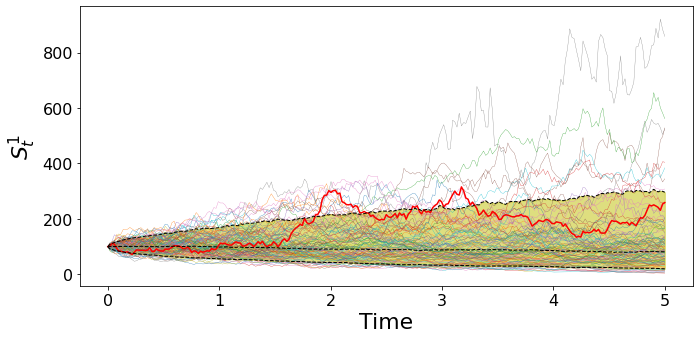

In [125]:
# Sim some paths and show sims with quantiles and a sample path
t, S = SimPathStocVol(Ndt=252, params = params_stvol, T=5, Nsims = 1000)
#t, S = SimPath(Ndt=252, params = params, T=5, Nsims = 1000)
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=22)
for i in range(S.shape[2]):
    
    plt.subplot(1,S.shape[2],i+1)
    
    plt.fill_between(t, np.quantile(S[:,:,i],0.1,axis=1).T, np.quantile(S[:,:,i],0.9,axis=1).T, color='y', alpha=0.5)
    plt.plot(t, S[:,:100,i],linewidth=0.3)
    plt.plot(t, S[:,0,i],color='r',linewidth=1.5)
    plt.plot(t, np.quantile(S[:,:,i],[0.1, 0.5, 0.9],axis=1).T,color='k',linewidth=1, linestyle='--')
    
    plt.xlabel("Time")
    plt.ylabel("$S_t^" +str(i+1)+"$")
    
plt.tight_layout()
plt.show()

In [126]:
# the ANN for policy iteration
class MyNet(nn.Module):
    
    def __init__(self, n, n_assets ):
        super(MyNet, self).__init__()

        # 2 input layer (t, X_t^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, n_assets)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        #y = y.clamp(-1,1)
        #y = F.logsigmoid(h2)
        
        return y

In [127]:
# from a minibatch compute the risk measure
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])
    
    # alpha-beta
    elif (Type == "alpha-beta" ):
        
        alpha = 0.1
        LQtl = torch.quantile(X,alpha)
        
        beta = 0.9
        UQtl = torch.quantile(X,beta)
        
        # weight factor (p in the paper)
        p = 0.75
        eta = p * alpha + (1-p) * (1-beta)
        RiskMeasure = -(p* torch.mean(X[X<=LQtl]) \
                        + (1-p) * torch.mean(X[X>=UQtl] ) )/eta
        
        
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [128]:
# from a minibatch compute the Wasserstein Distance
def getWassDistance(X, Y):
    
    # generate co-monotonic versions of the sample
    X_sorted, _ = torch.sort(X)
    Y_sorted, _ = torch.sort(Y)
    
    wass_dist = torch.sqrt(torch.mean(( X_sorted - Y_sorted )**2))
    
    return wass_dist 

In [129]:
# given an ANN run a simulation and compute the riskmeasure
from IPython.core.debugger import set_trace

def SimRM(net, Ndt, T, Nsims, params, device):
    
    t, S = SimPathStocVol(Ndt, params, T=T, Nsims=Nsims)  
      
    #t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
    #set_trace()
    # initial investment amount
    X0 = 1
    
    num_asset = S.shape[2]
    dt = t[1]-t[0]
    
    # don't think we need sensitivities w.r.t. this as they are fixed per simulation
    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    
    S_Ret = (S_t[1:,:,:]-S_t[:-1,:,:])/S_t[:-1,:,:]
    
    #Benchmark Delta and return
    Delta_t = torch.zeros((Ndt, Nsims, num_asset), \
                                 dtype=torch.float, requires_grad=False, device=device)
    # note only 90% invested in risky assets here... 10% in risk-free
    delta = torch.tensor(params["delta"],requires_grad=False, device=device)
    delta_r = 1 - torch.sum(delta)
    Delta_t += delta 

    # accumulate returns as we go along
    Benchmark_Ret = delta_r * params["rf"] * dt+ torch.sum(Delta_t * S_Ret , axis=2)
    
    BenchmarkVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)
    BenchmarkVal_path[0,:]  = X0
    BenchmarkVal_path[1:,:] = X0*torch.cumprod( (1.0+Benchmark_Ret), axis=0)
    BenchmarkVal_T = BenchmarkVal_path[-1,:].reshape(-1,1)
    #print(torch.mean(BenchmarkVal_path,1))
    #
    # Getting the portfolio weights using benchmark value and time as features
    #
    x=np.zeros((Ndt+1, Nsims, 2))   
    #set_trace()
    
    x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)
    xt = torch.tensor(x, dtype=torch.float, device=device)
    
    xt[:,:,1] = BenchmarkVal_path/X0
    
    wt = net(xt)    
    
    # the candidate portolio
    Portfolio_Ret = (1-torch.sum(wt[:-1,:,:], axis=2)) * params["rf"] * dt+ torch.sum(wt[:-1,:,:] * S_Ret , axis=2)
    
    PortfolioVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)    
    PortfolioVal_path[0,:] = X0
    PortfolioVal_path[1:,:] = X0*torch.cumprod( (1.0+Portfolio_Ret), axis=0)
    PortfolioVal_T = PortfolioVal_path[-1,:].reshape(-1,1)
        
    
    # Compute the risk measure and wasstertein Distance for the computation
    wass_dist = getWassDistance(PortfolioVal_T, BenchmarkVal_T)
    RiskMeasure = GetRiskMeasure(PortfolioVal_T, "alpha-beta") 
    
    return wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, t, BenchmarkVal_path.cpu().detach().numpy(), PortfolioVal_path.cpu().detach().numpy()

In [130]:
# plot histogram of portfolio, sample path, and show dependence of X^\pi on X^\delta
def PlotHists(X, Y, t, X_path, Y_path):
    
    Xcp = X.clone().cpu().detach().numpy()
    Ycp = Y.clone().cpu().detach().numpy()
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    bins = np.linspace(0,4,50)
    
    sns.distplot(Xcp, hist=True, kde=True,  bins=bins, label='Benchmark')
    sns.distplot(Ycp,  hist=True, kde=True, bins=bins, label='Portfolio')  
    
    plt.axvline(np.quantile(Xcp, 0.05),color='k',linewidth=0.5)
    plt.axvline(np.quantile(Ycp, 0.05),color='r',linewidth=0.5)
    
    plt.legend()
    plt.xlim(0,4)
    

    plt.subplot(1,3,2)
    plt.fill_between(t, np.quantile(X_path,0.1,axis=1).T, np.quantile(X_path,0.9,axis=1).T, color='y', alpha=0.5)
    plt.fill_between(t, np.quantile(Y_path,0.1,axis=1).T, np.quantile(Y_path,0.9,axis=1).T, color='g', alpha=0.5)
    plt.plot(t,X_path[:,0], label='Benchmark', color='r')
    plt.plot(t,np.quantile(X_path,[0.1,0.5,0.9],axis=1).T, '--y')
    plt.plot(t,Y_path[:,0], label='Portfolio', color='k')
    plt.plot(t,np.quantile(Y_path,[0.1,0.5,0.9],axis=1).T, '--g')
    
    plt.legend()
    
    
    plt.subplot(1,3,3)
    xs = [min(Xcp), max(Xcp)]
    plt.plot(xs,xs,'--k' )
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    plt.xlim(0,5)
    plt.ylim(0,5)
    
    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)
    
    plt.tight_layout()
    
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


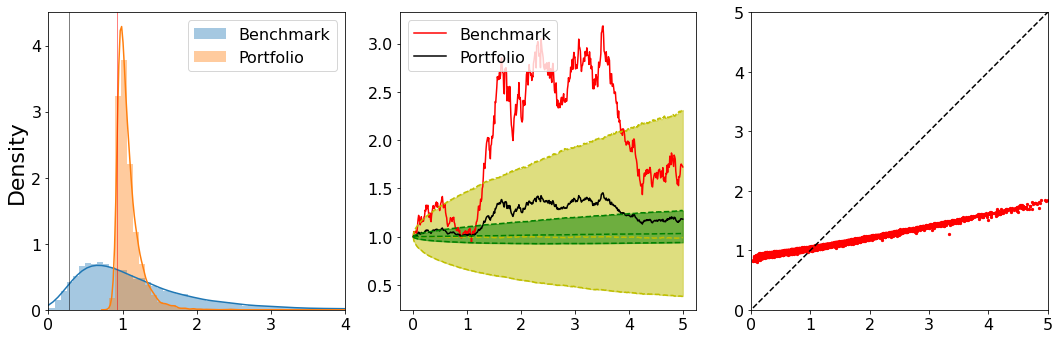

In [131]:
# create an ANN and use GPU if available

if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

net = MyNet(50, len(params["S0"])).to(device)

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)


In [132]:
PortfolioVal_path.shape

(501, 10000)

In [133]:
torch.cuda.is_available()

True

...........10 duaration =  9.268  secs
Wass Dist: 0.424 Risk Measure: -8.224 Loss: 34.154


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


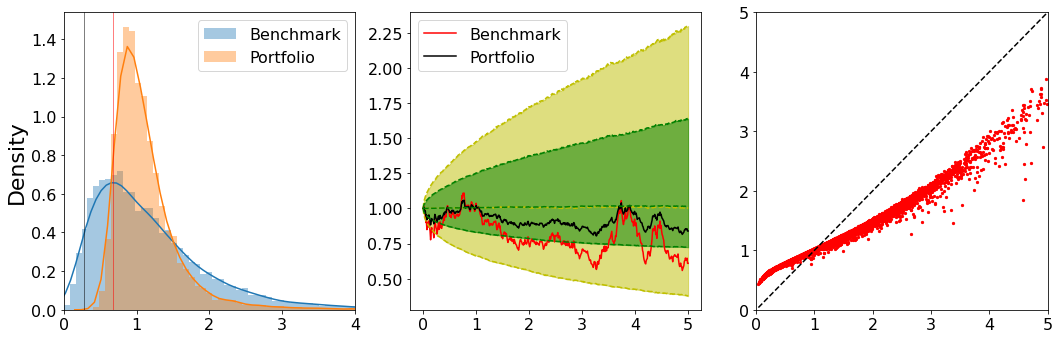

1.1476152 1.0825821

..........20 duaration =  10.447  secs
Wass Dist: 0.398 Risk Measure: -7.997 Loss: -7.997


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


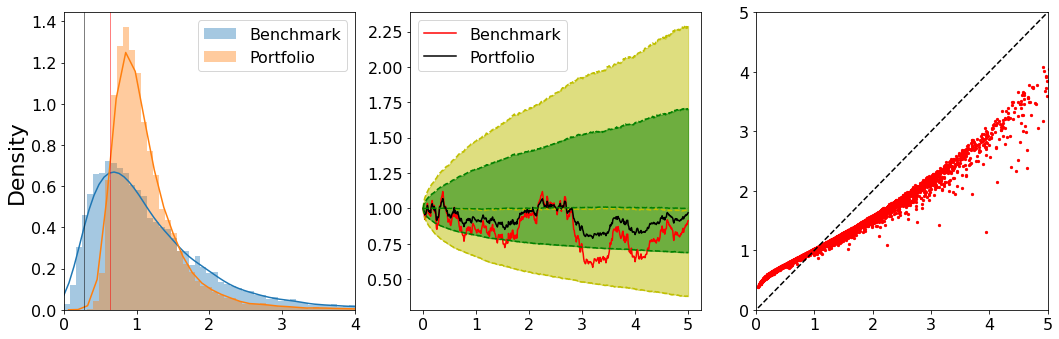

1.1588931 1.0998652

..........30 duaration =  10.318  secs
Wass Dist: 0.468 Risk Measure: -8.083 Loss: 38.689


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


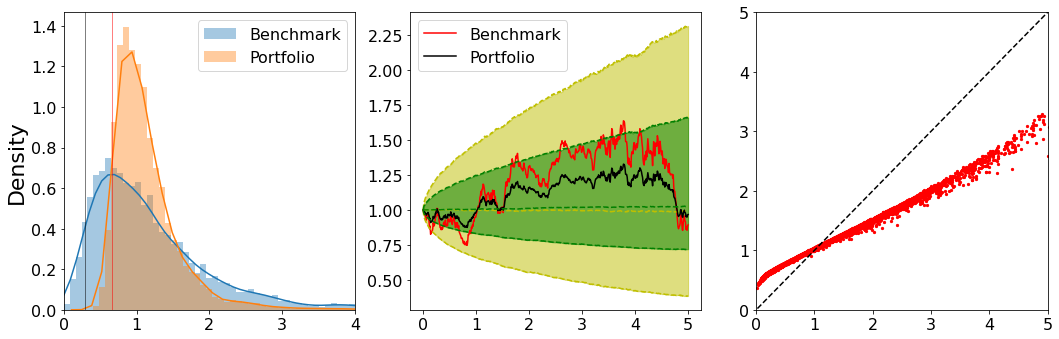

1.1419318 1.0727481

..........40 duaration =  10.318  secs
Wass Dist: 0.497 Risk Measure: -7.762 Loss: 41.897


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


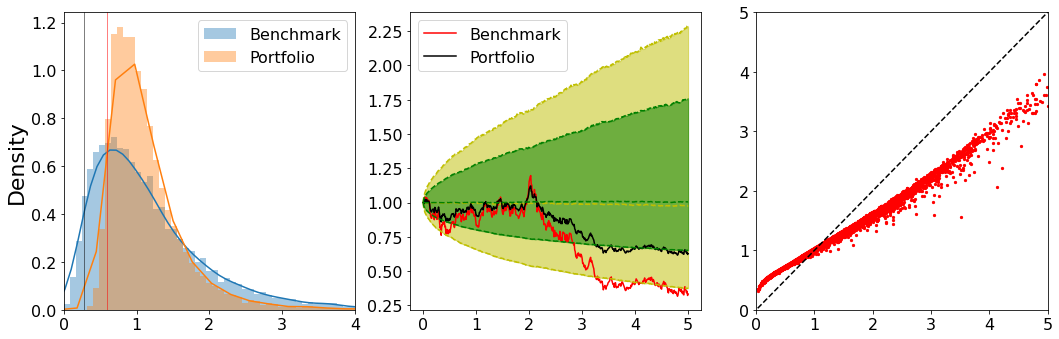

1.1452869 1.0854663

..........50 duaration =  10.385  secs
Wass Dist: 0.395 Risk Measure: -7.663 Loss: -7.663


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


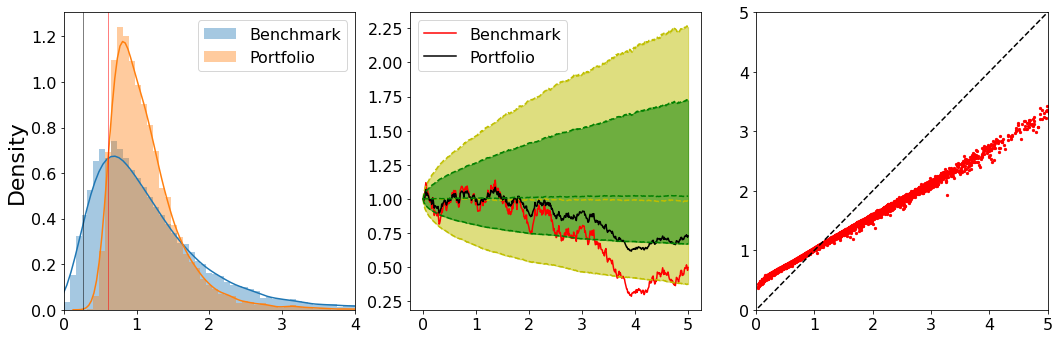

1.152608 1.0865166

..........60 duaration =  10.323  secs
Wass Dist: 0.367 Risk Measure: -7.854 Loss: -7.854


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


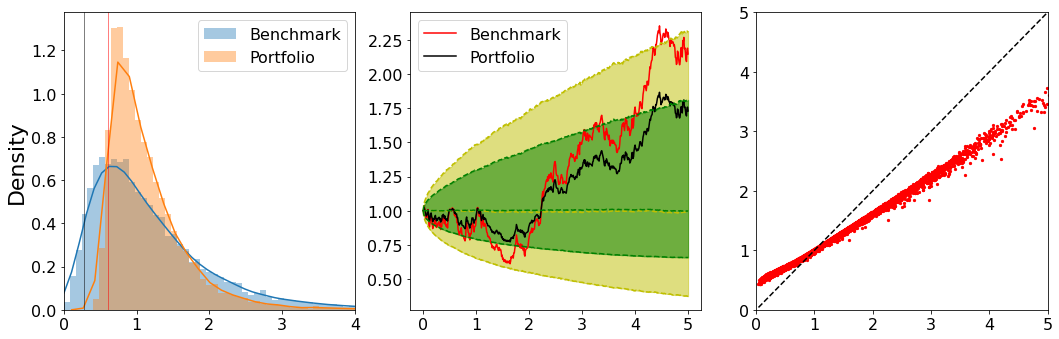

1.1420543 1.0862308

..........70 duaration =  10.284  secs
Wass Dist: 0.362 Risk Measure: -8.364 Loss: -8.364


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


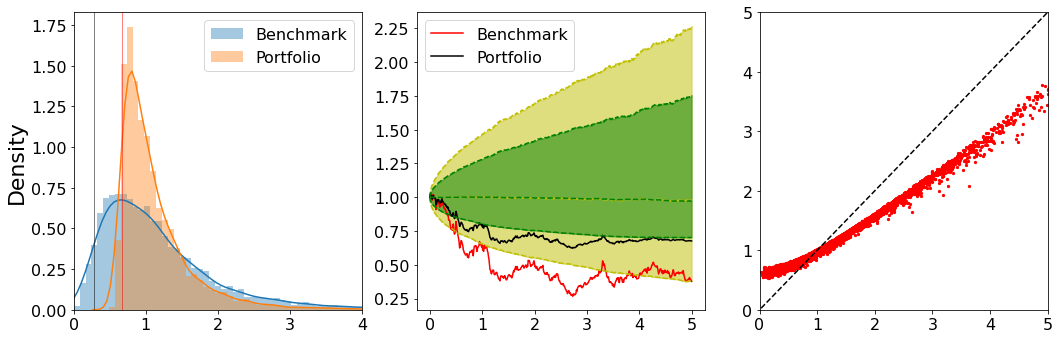

1.1465906 1.084351

..........80 duaration =  10.193  secs
Wass Dist: 0.372 Risk Measure: -8.638 Loss: -8.638


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


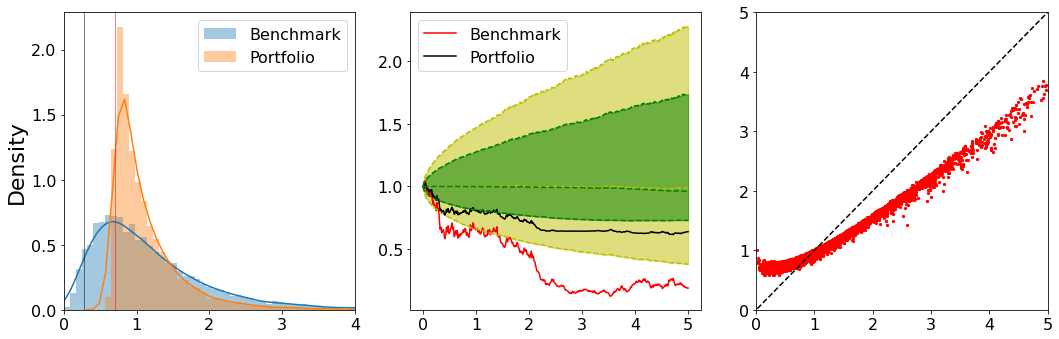

1.1616106 1.0931467

..........90 duaration =  10.331  secs
Wass Dist: 0.391 Risk Measure: -8.726 Loss: -8.726


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


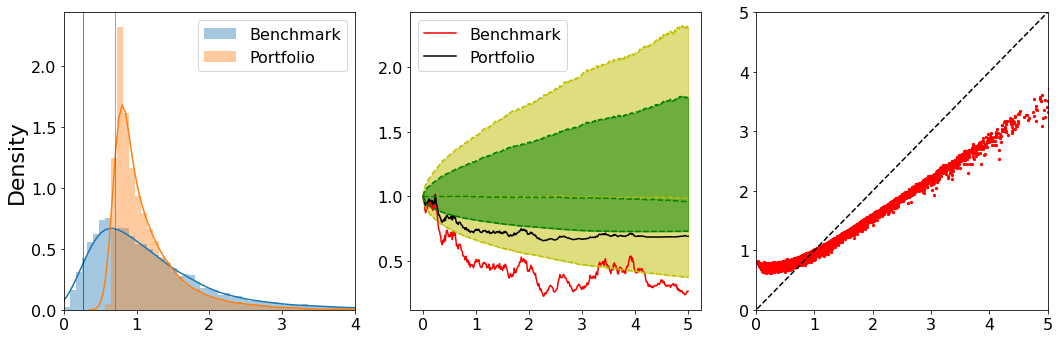

1.142822 1.0760866

..........100 duaration =  10.197  secs
Wass Dist: 0.364 Risk Measure: -8.523 Loss: -8.523


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


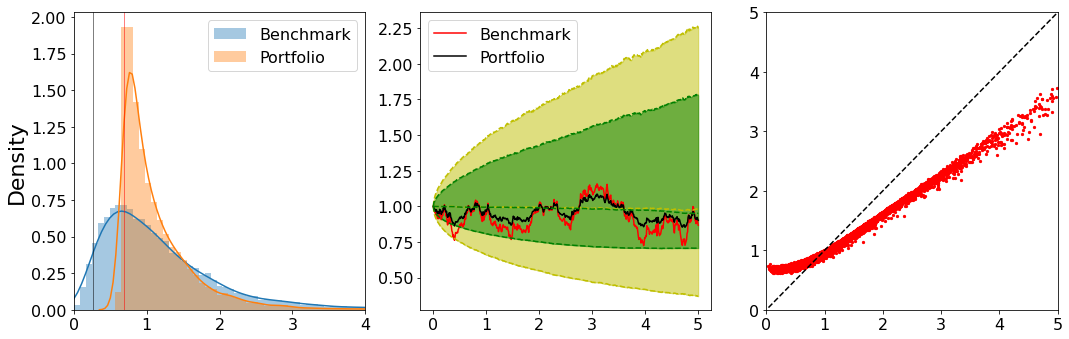

1.1403546 1.0827763

..........110 duaration =  10.229  secs
Wass Dist: 0.353 Risk Measure: -8.687 Loss: -8.687


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


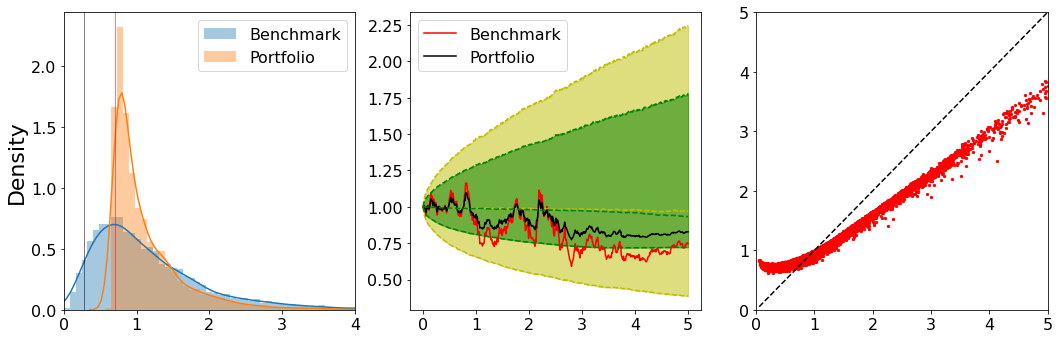

1.1489778 1.0842772

..........120 duaration =  10.184  secs
Wass Dist: 0.397 Risk Measure: -9.081 Loss: -9.081


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


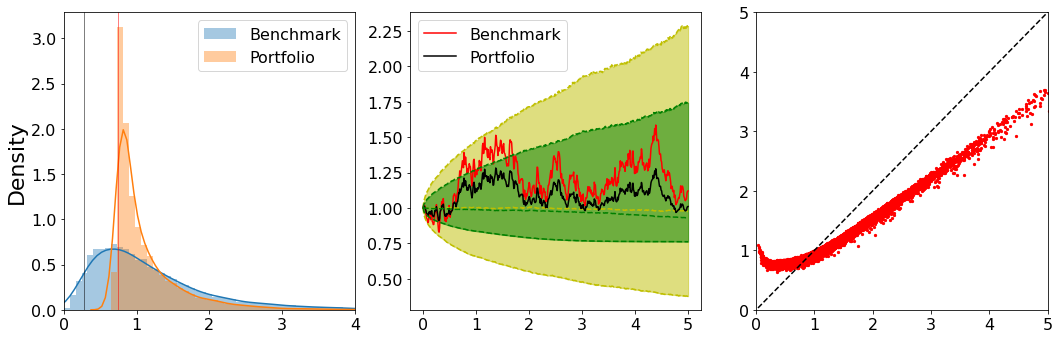

1.1440272 1.074409

..........130 duaration =  10.296  secs
Wass Dist: 0.335 Risk Measure: -8.769 Loss: -8.769


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


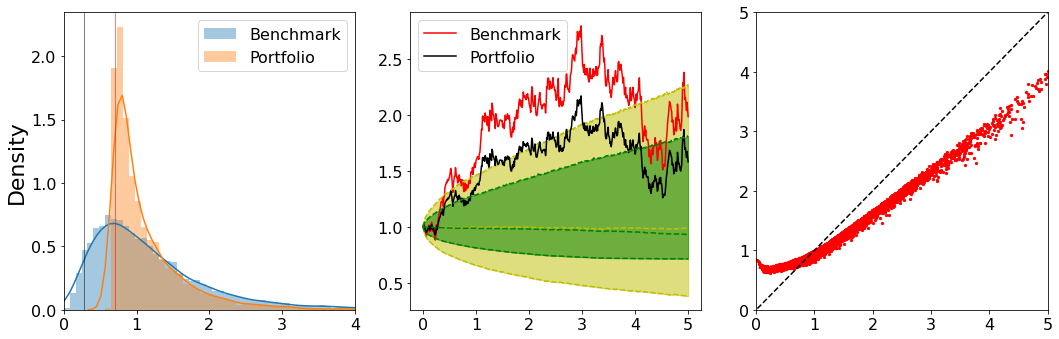

1.1578555 1.0899111

..........140 duaration =  10.249  secs
Wass Dist: 0.370 Risk Measure: -8.042 Loss: -8.042


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


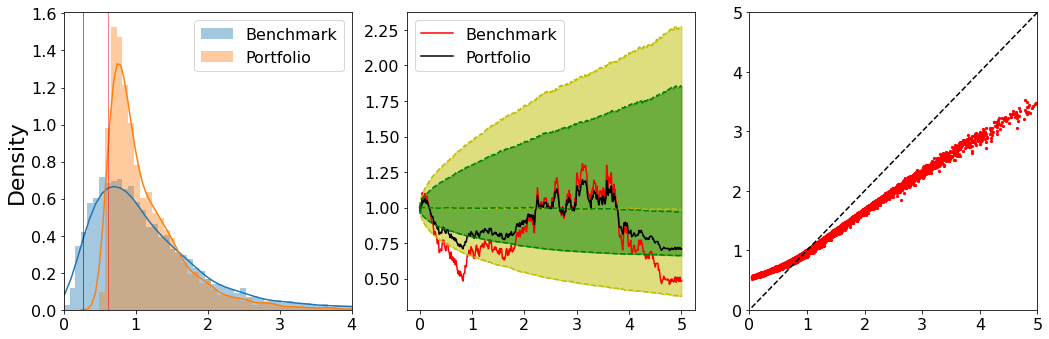

1.1475459 1.0929903

..........150 duaration =  10.230  secs
Wass Dist: 0.263 Risk Measure: -7.717 Loss: -7.717


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


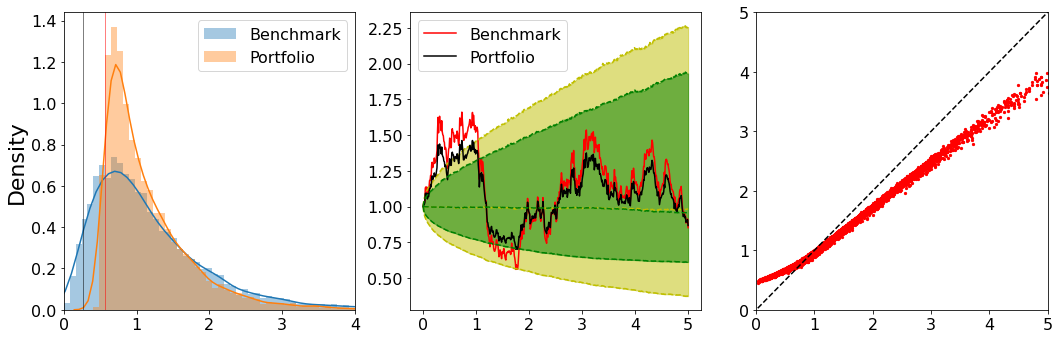

1.1533378 1.1079326

..........160 duaration =  10.290  secs
Wass Dist: 0.256 Risk Measure: -7.968 Loss: -7.968


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


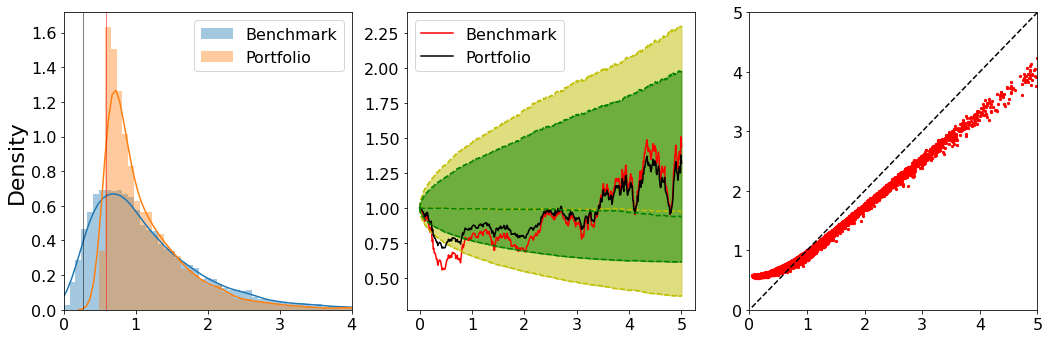

1.1500978 1.1048965

..........170 duaration =  10.211  secs
Wass Dist: 0.280 Risk Measure: -8.400 Loss: -8.400


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


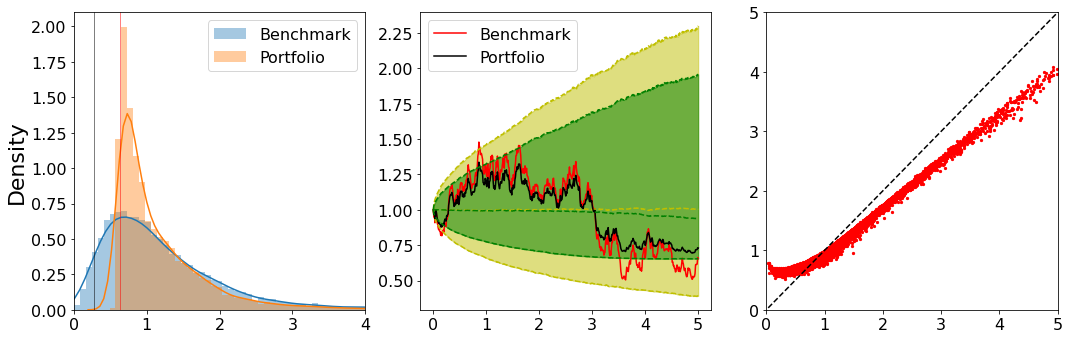

1.1523408 1.1013483

..........180 duaration =  10.192  secs
Wass Dist: 0.308 Risk Measure: -8.585 Loss: -8.585


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


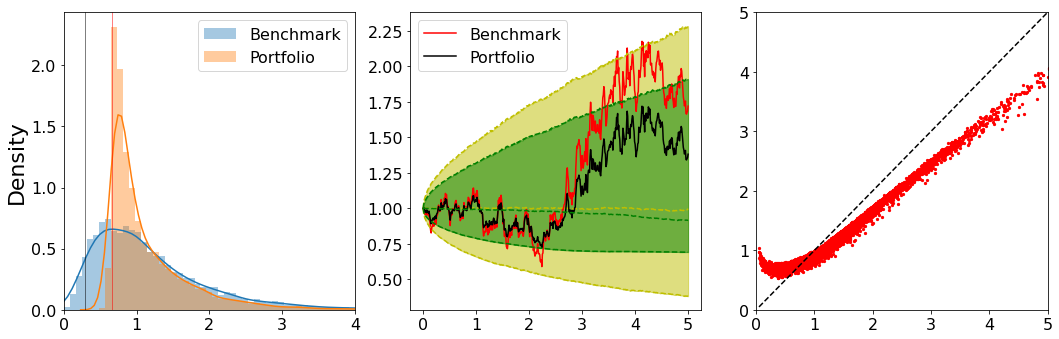

1.1570742 1.0994699

..........190 duaration =  10.201  secs
Wass Dist: 0.365 Risk Measure: -8.862 Loss: -8.862


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


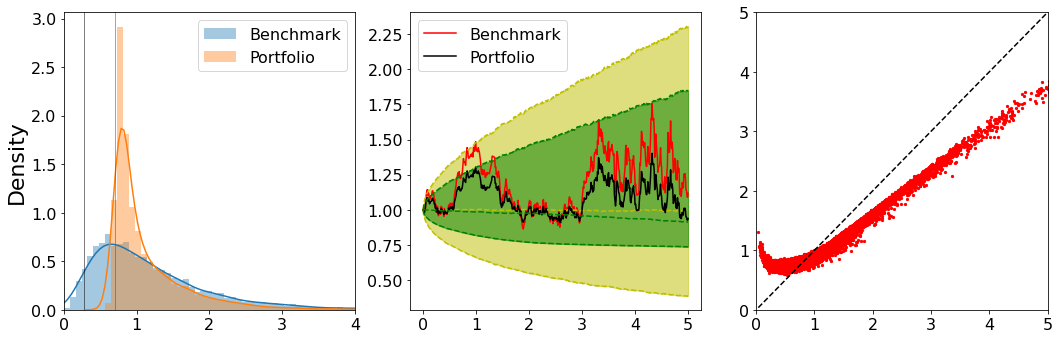

1.1474671 1.0800967

..........200 duaration =  10.315  secs
Wass Dist: 0.351 Risk Measure: -9.036 Loss: -9.036


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


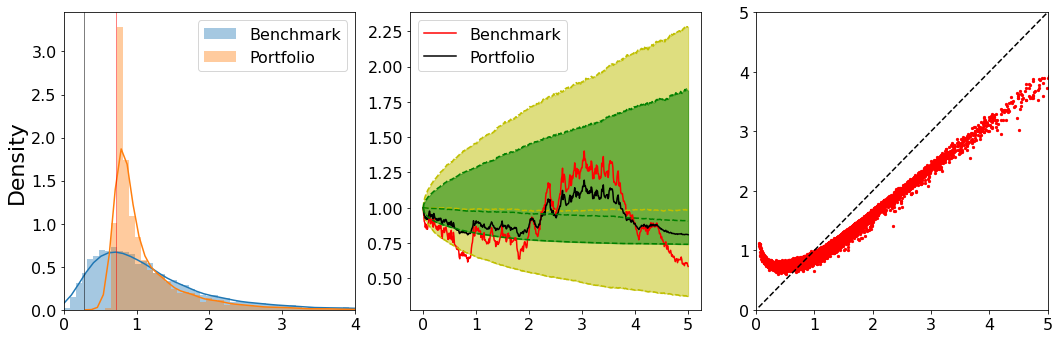

1.1531465 1.08952

..........210 duaration =  10.230  secs
Wass Dist: 0.311 Risk Measure: -9.085 Loss: -9.085


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


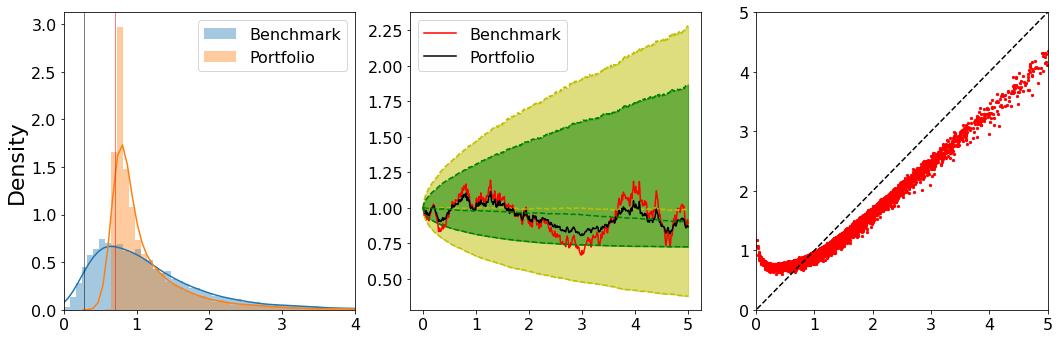

1.1481067 1.0906012

..........220 duaration =  10.321  secs
Wass Dist: 0.334 Risk Measure: -9.208 Loss: -9.208


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


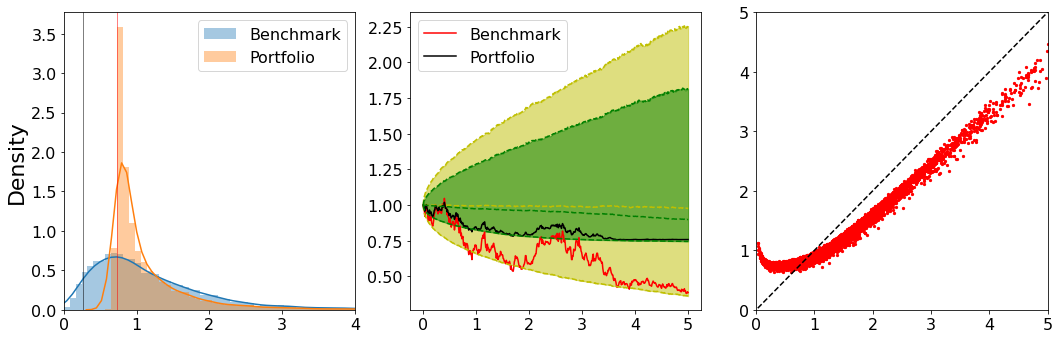

1.1529974 1.0931638

..........230 duaration =  10.203  secs
Wass Dist: 0.393 Risk Measure: -9.424 Loss: -9.424


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


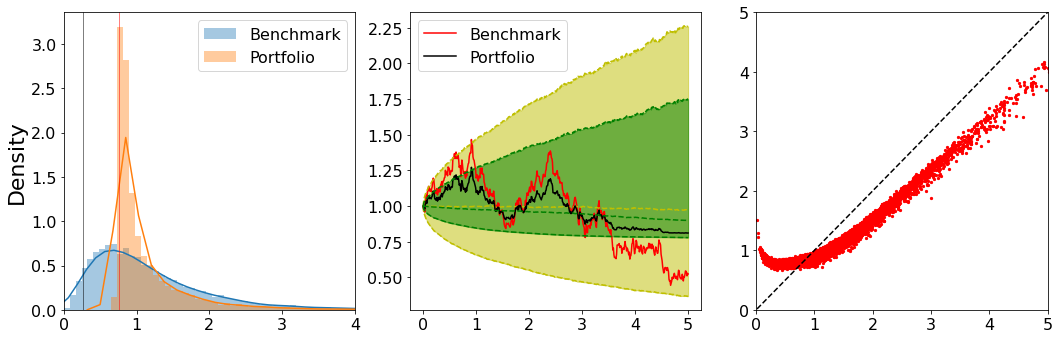

1.1400174 1.07109

..........240 duaration =  10.273  secs
Wass Dist: 1.960 Risk Measure: -9.585 Loss: 186.383


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


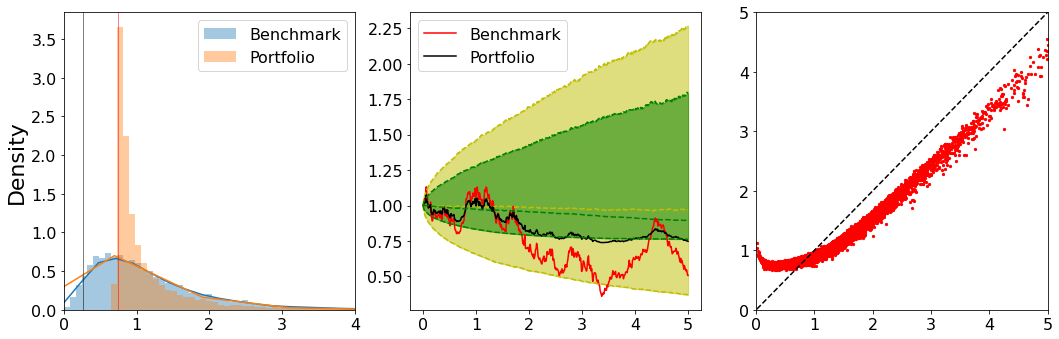

1.1401904 1.0748245

..........250 duaration =  10.156  secs
Wass Dist: 0.589 Risk Measure: -8.332 Loss: 50.615


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


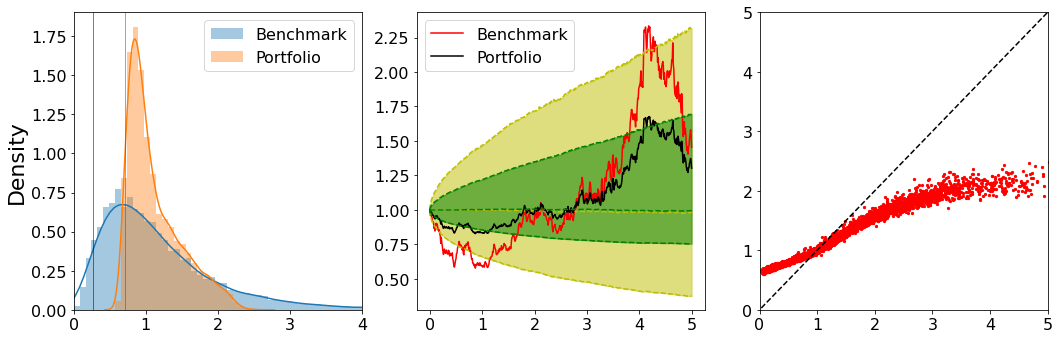

1.1474979 1.0653911

..........260 duaration =  10.205  secs
Wass Dist: 0.525 Risk Measure: -6.375 Loss: 46.106


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


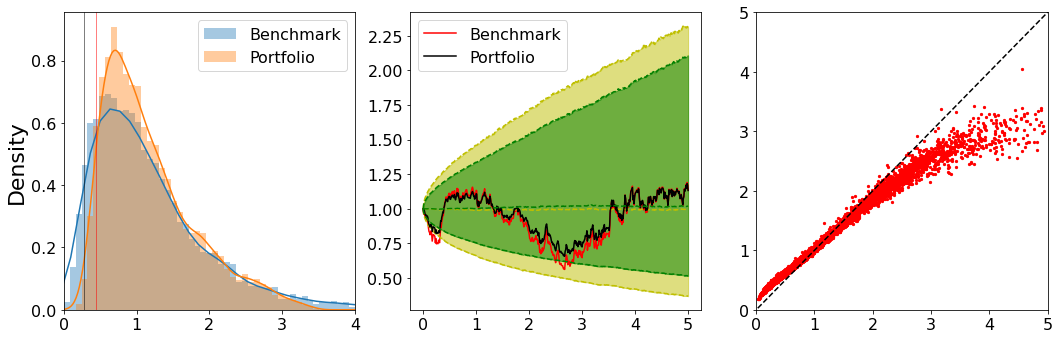

1.1431817 1.1092626

..........270 duaration =  10.288  secs
Wass Dist: 0.158 Risk Measure: -6.239 Loss: -6.239


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


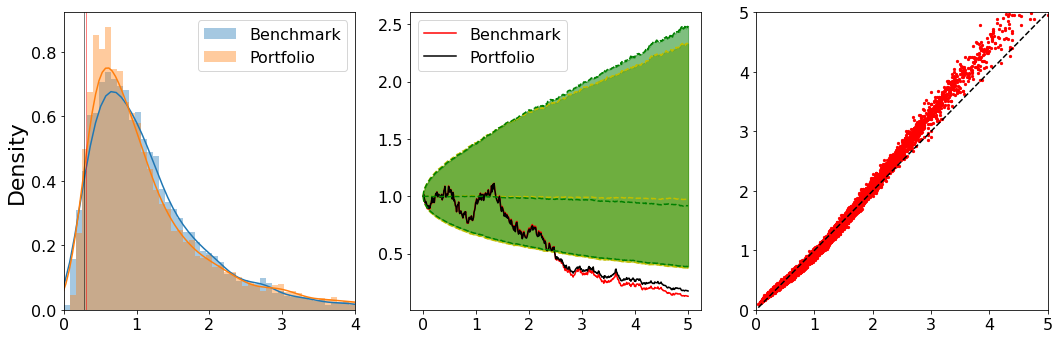

1.1505362 1.1641381

..........280 duaration =  10.172  secs
Wass Dist: 0.271 Risk Measure: -6.403 Loss: -6.403


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


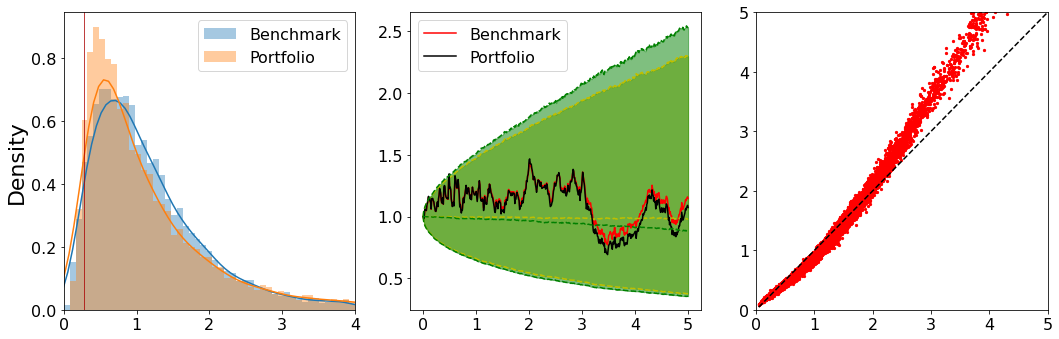

1.1637312 1.1956748

..........290 duaration =  10.201  secs
Wass Dist: 0.386 Risk Measure: -6.586 Loss: -6.586


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


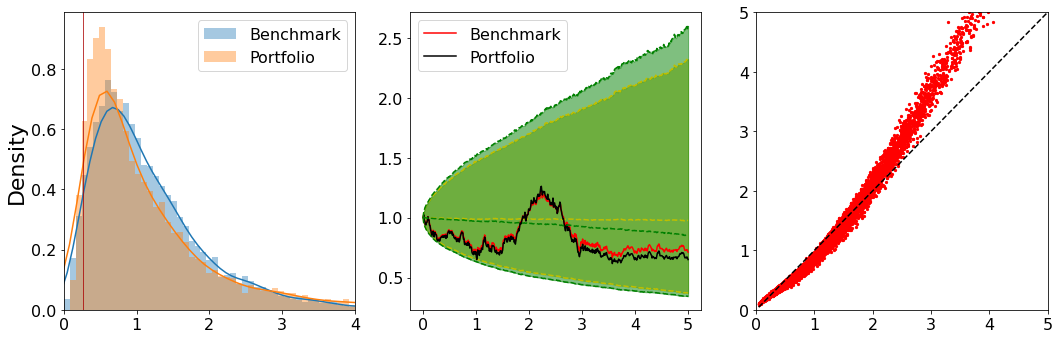

1.1395612 1.1724325

.........Finished Training


In [134]:
# train the model

optimizer = optim.Adam(net.parameters())


Nepochs = 1000
loss_hist = []
risk_history = []
wass_dist_history=[]

start_time= time.time()

for epoch in range(Nepochs):  # loop over the dataset multiple times

    
    
    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    wt, RiskMeasure, wass_dist, PortfolioVal_T, IndexVal_T, t, IndexVal_path, PortfolioVal_path \
        = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params, device=device)
    
    #loss = 100*(wass_dist)*(wass_dist>0.2) + RiskMeasure +100*(wass_dist)*(wass_dist>0.15)
    loss = 100*(wass_dist)*(wass_dist>0.4) + RiskMeasure 
    
    loss.backward()   
    
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.cpu().detach().numpy() )
    wass_dist_history.append( wass_dist.cpu().detach().numpy() )
    
    print(".",end="")
    
    # plot output every 50 iterations
    if( (epoch % 10 == 0) and (epoch>1) ):
        
        print(epoch, end=" ")
        print("duaration = ", "{:.3f}".format(time.time() - start_time), " secs")
        start_time = time.time()
        
        print("Wass Dist:", "{:.3f}".format(wass_dist_history[-1]), end=" " )
        print("Risk Measure:", "{:.3f}".format(risk_history[-1]), end=" ")
        print("Loss:", "{:.3f}".format(loss.item()))

        PlotHists(IndexVal_T, PortfolioVal_T, t, IndexVal_path, PortfolioVal_path)
                
        
        _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
        print(np.mean(np.exp(-params_Q["rf"]*5) * BenchmarkVal_T_Q.cpu().detach().numpy()), end=" ")
        print(np.mean(np.exp(-params_Q["rf"]*5) * PortfolioVal_T_Q.cpu().detach().numpy()), end="\n\n")        
        

print('Finished Training')

In [135]:
X_pi_T = np.zeros((0,1))
X_delta_T = np.zeros((0,1))
for i in range(10):
    _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
    X_pi_T = np.concatenate((X_pi_T,PortfolioVal_T_Q.cpu().detach().numpy()))
    X_delta_T = np.concatenate((X_pi_T,BenchmarkVal_T_Q.cpu().detach().numpy()))
    
print(np.mean(np.exp(-params_Q["rf"]*5) * X_delta_T), end=" ")
print(np.mean(np.exp(-params_Q["rf"]*5) * X_pi_T), end="\n\n")  

1.1791390981971843 1.1819126426101312



In [136]:
X_delta_T.shape

(110000, 1)

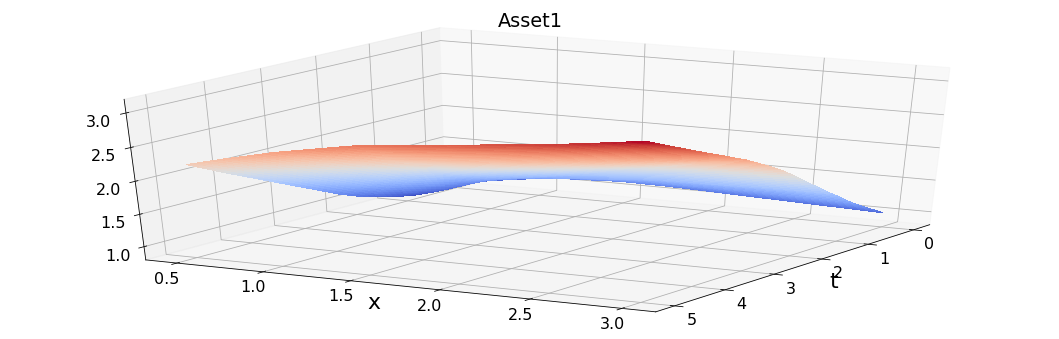

In [137]:
def PlotStrat(net, device):
    
    t = np.linspace(0, 5, 100)
    X_delta_t = np.linspace(0.5, 3, 100)
     
    x1, x2 = np.meshgrid(t, X_delta_t)
    
    x = np.zeros((x1.shape[0], x1.shape[1], 2))
    
    x[:,:,0] = x1
    x[:,:,1] = x2
    
    x_t = torch.tensor(x, dtype=torch.float, device=device )
    
    w_t = net(x_t).cpu().detach().numpy()
        
    fig = plt.figure(figsize=(15,5))

    #params["delta"]
    
    for i in range(w_t.shape[2]):
            
        ax = fig.add_subplot(1, w_t.shape[2], i+1, projection='3d')
        #Normalizing the weights to get the ratio of portfolio and benchmark weight
        ax.plot_surface(x1, x2, w_t[:,:,i]/params["delta"][i], cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
        ax.view_init(30, 30)
        
        plt.title('Asset' + str(i+1))
        
        plt.xlabel('t')
        plt.ylabel('x')
    
    plt.tight_layout()
    plt.show()
    
    
    # for i in range(0,x1.shape[1],5):
    
    #     fig = plt.figure(figsize=(10,5))
    
    #     plt.subplot(1,3,1)
    #     plt.plot(X_delta_t, w_t[:,i,0])
        
    #     plt.subplot(1,3,2)
    #     plt.plot(X_delta_t, w_t[:,i,1])

    #     plt.subplot(1,3,3)
    #     plt.plot(X_delta_t, w_t[:,i,1])
        
    #     plt.suptitle("t={0:0.2f}".format(t[i]) , fontsize= 20 )
    #     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #     plt.show()
    
    
PlotStrat(net, device)
    

### Backtesting

In [138]:
#backtesting_params = params

# backtesting_params = {
#     "S0" : np.array([1]),
#     "mu" : np.array([0.03]),
#     "sigma" : np.array([0.3]),
#     "rho" : np.array([[1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.7])
#     }

backtesting_params = {
    "S0" : np.array([1, 1]),
    "mu" : np.array([0.05, 0.05]),
    "sigma" : np.array([0.1, 0.8]),
    "rho" : np.array([[1, .25],[.25,1]]),
    "rf" : 0.01,
    "delta" : np.array([0.5, 0.5])
    }

# backtesting_params = {
#     "S0" : np.array([1, 2,3,1]),
#     "mu" : np.array([0.5, 0.06, .06, .06]),
#     "sigma" : np.array([.7, 0.30 , .10, .10]),
#     "rho" : np.array([[1, 0.25,.25, .25],[0.25,1,.25, .25], [0.25,.25,1, .25], [0.25,.25,.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.2, 0.3, .3, .4 ])
#     }

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=500, T=5, Nsims=1, params=backtesting_params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)

/usr/local/lib/python3.6/dist-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = N.array(data, dtype=dtype, copy=copy)


ValueError: ignored

In [ ]:
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,0], label='Asset1', color='r')
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,1], label='Asset2', color='b')
plt.legend()

In [ ]:
wt

In [ ]:
#%debug

In [ ]:
import pickle 

In [ ]:
pickle.dump( net, open( "net_Nov2.p", "wb" ) )